# CapsNet MNIST

This is an implementation of Geoffrey Hinton's CapsNet architecture as described in [Sabour 2017]. The implementation is (very) insipired by Aurélien Géron's implementation and is for learning purposes only.

## Setup

In [1]:
# Imports
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# TODO adjust matplotlib settings for Jupyter Notebooks
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Stabilize ouptut accross runs
# TODO give the caller more control over what to reset

def reset(seed=42):
    tf.reset_default_graph()
    np.random.seed(seed)
    tf.set_random_seed(42)

## MNIST Dataset

In [3]:
# TODO this method of loading mnist appears to be deprecated;
#     => error message: "Please use alternatives such as official/mnist/dataset.py from tensorflow/models."
# TODO switch to `tf.data.Dataset`

mnist = input_data.read_data_sets("/tmp/data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def peek_data(n_samples=5):
    plt.figure(figsize=(n_samples * 2, 3))
    
    for index in range(n_samples):
        plt.subplot(1, n_samples, index + 1)
        
        # images are stored as flattened numpy arrays
        sample_image = mnist.train.images[index].reshape(28, 28)
        
        plt.imshow(sample_image, cmap="binary")
        plt.axis("off")
    
    plt.show()
    
    
def peek_labels(n_samples=5):
    print(mnist.train.labels[:n_samples])

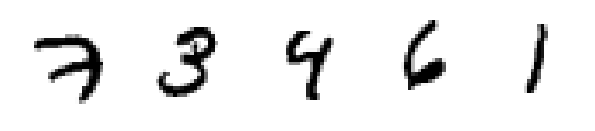

In [5]:
peek_data()

In [6]:
peek_labels()

[7 3 4 6 1]


## CapsNet model

In [7]:
reset()

## Input

# tf.layers.conv2d expects tensors of shape (batch_size, width, height, channels)
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")


## Conv1

# The Conv1 layer is purely convolutional, with 256 9x9 kernels, a stride of 1 and ReLU activations. Its purpose is 
# to extract visual features from pixels. Its output will be a tensor of shape (batch_size, 20, 20, 256)
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid", # don't use zero-padding
    "activation": tf.nn.relu,
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)


## PrimaryCaps
# TODO make this a layer, similar to tf.layers.conv2d

# In the 2017 paper, the probability that the object detected by the capsule is present has been
# represented by the length of the capsules activation vector. Hinton backtracked on this in his
# recent paper "Matrix Capsules with EM Routing", since the use of the `squash` non-linearity 
# is unprincipled and brings some numerical issues.

# TODO try the Hinton 2018 capsule design

# a numerically stable implementation of the squash function
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
        
        # approximate norm(s) by sqrt(sum_i s_i^2 + epsilon) to prevent division by zero
        safe_norm = tf.sqrt(squared_norm + epsilon)
        
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        
        return squash_factor * unit_vector

    
with tf.name_scope('primaryCaps') as scope:
    # The PrimaryCaps layer is the first layer of capsules, containing 32 channels of 8D capsules
    # The capsule components are computed by applying a convolution (9x9 kernel, stride of 2) on the
    # 256 20x20 feature maps of the Conv1 layer. The resulting 256 6x6 feature maps are then grouped
    # accross feature maps (ie. accross the `channel` dimension) into 32 6x6 maps of 8D capsules,
    # resulting in 1152 primary capsules in total
    primaryCaps_n_maps = 32
    primaryCaps_n_dims = 8
    primaryCaps_n_caps = primaryCaps_n_maps * 6 * 6 # 1152

    # The PrimaryCaps layer is a convolutional capsule layer acting on the feature maps of Conv1. 
    primaryCaps_conv_params = {
        "filters": primaryCaps_n_maps * primaryCaps_n_dims,
        "kernel_size": 9,
        "strides": 2,
        "padding": "valid",
        "activation": tf.nn.relu,
    }

    primaryCaps_conv = tf.layers.conv2d(conv1, name="primaryCaps_conv", **primaryCaps_conv_params)

    # The proper way would be to reshape the (batch_size, 6, 6, 256) to (batch_size, 6, 6, 32, 8). 
    # However, since this layer is fully connected to the next layer, Ageron simply reshapes to
    # a (quasi) flat tensor of 1152 8D capsules (ie. (batch_size, 6x6x32, 8))

    # TODO this approach doesn't support stacking convolutional capsule layers. Make this more general!
    primaryCaps_raw = tf.reshape(
        primaryCaps_conv, 
        shape=[-1, primaryCaps_n_caps, primaryCaps_n_dims],
        name="primaryCaps_raw"
    )
    
    primaryCaps_output = squash(primaryCaps_raw, name="primaryCaps_output")


## DigitCaps
# TODO make this a layer, similar to tf.layers.dense

# The second layer of capsules contains 10 16D capsules (one per digit class). 
digitCaps_n_caps = 10
digitCaps_n_dims = 16

# The PrimaryCaps layer is fully connected
# to this layer, ie. every primary capsule i predicts the estimation of every digit capsule j via a transformation 
# matrix W_ij applied to its own activation (ie. u_pred,j|i = W_ij u_i).

# tf.matmul applied to higher-dimensional tensors treats these as arrays of matrices and performs element-wise
# matrix multiplication on them. We will use this to efficiently compute a tensor of 16D prediction vectors
# (laid out as columns vectors) of dimension (batch_size, primaryCaps_n_caps, digitCaps_n_caps, digitCaps_n_dims, 1).
# To this end, we create a tensor of shape 
# (batch_size, primaryCaps_n_caps, digitCaps_n_caps, digitCaps_n_dims, primaryCaps_n_dims) containing a
# (primaryCaps_n_caps, digitCaps_n_caps) array of transformation matrices, replicated accross the `batch_size`
# dimension. This tensor is multiplied as outlined above with another tensor of shape 
# (batch_size, primaryCaps_n_caps, digitCaps_n_caps, primaryCaps_n_dims, 1) representing an array of similar shape
# containing the digitCaps_n_dims dimensional activation vectors of the digitCaps layer replicated accross
# the `digitCaps_n_caps` dimension.
# I probably won't understand any of this myself when I look at it a second time...

# Create a (primaryCaps_n_caps, digitCaps_n_caps) array of transformation matrices
sigma = 0.1

W = tf.Variable(
    tf.random_normal(
        shape=(1, primaryCaps_n_caps, digitCaps_n_caps, digitCaps_n_dims, primaryCaps_n_dims),
        stddev=sigma,
        dtype=tf.float32
    ),
    name = "W",
)

# Replicate the array of transformation matrices accross the `batch_size` dimension
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

# Convert the output of the PrimaryCaps layer into column vectors
primaryCaps_output_columns = tf.expand_dims(primaryCaps_output, -1, name="primaryCaps_output_columns")

# Add the `primaryCaps_n_caps` dimension
primaryCaps_output_tile = tf.expand_dims(primaryCaps_output_columns, 2, name="primaryCaps_output_tile")

# Replicate primaryCaps ouptut column vectors accross the `primaryCaps_n_caps` dimension
primaryCaps_output_tiled = tf.tile(
    primaryCaps_output_tile, 
    [1, 1, digitCaps_n_caps, 1, 1], 
    name="primaryCaps_output_tiled"
)

# Multiply both tensors to get the predictions for the DigitCaps layer
digitCaps_predictions = tf.matmul(W_tiled, primaryCaps_output_tiled, name="digitCaps_predictions")

## Routing by agreement


# This simple form of routing by agreement basically performs coincidence filtering in the prediction space via
# K-means clustering with K=1. A more complex and flexible procedure has been outlined by Hinton in his 2018 paper
# TODO implement EM routing

# Routing in CpasNets works in the following way: a primary capsule sends each digit capsule its respective prediction
# vector. This input signal is dampened by a coupling coefficient. The coupling coefficients c_ij connecting a primary
# capsule i to a digit capsule j represent the probabilitic beliefs that the object detected by capsule i is part
# of the object detected by capsule j. Therefore, the c_ij's have to sum to one over all digit capsules for a
# particular primary capsule. This is modeled by a set of log priors b_ij which are iteratively tuned during top-down
# feedback


### Round 1
# This implementation explicitly specifies two rounds of routing. This is not only ugly, it also doesn't scale
# to a higher number of rounds.
# TODO put this in a look and make the number of iterations a hyperparamter

# Initialize a set of log priors

# Note: The idea here is to create a tensor of log_priors which can be multiplied elementwise with the 
# `digitCaps_predictions` tensor. This will be done using tf.multiply on higher-dimensional tensors as has been
# done above when computing the predicitions. Since `digitCaps_predictions` is a 
# (batch_size, primaryCaps_n_caps, digitCaps_n_caps) array of (digitCaps_n_dims, 1)-shaped column-vectors, and 
# the log_prior tensor must be of the same rank, `log_priors` will have a seemingly redundant last dimension of size 1.

# Note: Those are constants! They will (or should?) not be modified during training. Hinton says that log priors could
# be trained discriminatively, but they simply use 0's (ie. equally distributed priors).
# TODO: is this right? should they be learned? investiage!
log_priors = tf.zeros([batch_size, primaryCaps_n_caps, digitCaps_n_caps, 1, 1], dtype=tf.float32, name="log_priors")


# Apply softmax accross the `digitCaps_n_caps` dimension to compute coupling coefficients from log priors 
coupling_coefficients = tf.nn.softmax(log_priors, axis=2, name="coupling_coefficients")

# Weight predictions with coupling coefficients
# Since each vector in `digitCaps_predictions` is multiplied with a scalar, the result will again be a tensor of shape
# (batch_size, primaryCaps_n_caps, digitCaps_n_caps, digitCaps_n_dims, 1)
weighted_predictions = tf.multiply(coupling_coefficients, digitCaps_predictions, name="weighted_predictions")

# Accumulate incoming weighted_predictions for each digit capsule, creating a tensor of 
# shape (batch_size, 1, 10, 16, 1)
weighted_sums = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True, name="weighted_sums")

# Apply the squash-nonlinearity on each 16D prediction vector to compute the digit capsule's outputs
# for the first iteration
digitCaps_output_round_1 = squash(weighted_sums, axis=-2, name="caps_output_round_1")

### Round 2
# Predictions close to the output of a digit capsule (ie. tight clusters in prediction space) should be reinforced
# via top-down feedback. In this version of routing by agreement, this is done by computing the "agreement" (the 
# scalar product) between these two vectors, treat the result as a log likelihood and add it to the corresponding
# initial log_prior b_i,j. 
# Hinton acknowledges that this is an "ugly hack", but it works and it's fast. For a better (yet, slower) method
# consult "Matrix capsules with EM-Routing"

# Compute the scalar product uhat_j|i * v_j for each pair of primary capsules i and digit capsules j. 
# We therefore replicate `digitCaps_output_round_1` along the formerly reduced `primaryCaps_n_caps` dimension
digitCaps_output_round_1_tiled = tf.tile(
    digitCaps_output_round_1,
    [1, primaryCaps_n_caps, 1, 1, 1],
    name="digitCaps_output_round_1_tiled"
)

# tf.matmul applied to tensors of rows and column vectors computes the element-wise scalar product of these vectors
agreement = tf.matmul(digitCaps_predictions, digitCaps_output_round_1_tiled, transpose_a=True, name="agreement")

# update the log_priors
log_priors_round_2 = tf.add(log_priors, agreement, name="log_priors_round_two")

# the rest is analogous to the computations in round one
coupling_coefficients_round_2 = tf.nn.softmax(log_priors_round_2, axis=2, name="coupling_coefficients_round_2")

weighted_predictions_round_2 = tf.multiply(
    coupling_coefficients_round_2,
    digitCaps_predictions,
    name="weighted_predictions_round_2"
)

weighted_sums_round_2 = tf.reduce_sum(
    weighted_predictions_round_2,
    axis=1,
    keepdims=True,
    name="weighted_sums_round_2"
)

digitCaps_output_round_2 = squash(weighted_sums_round_2, axis=-2, name="digitCaps_output_round_2")
digitCaps_output = digitCaps_output_round_2


# Predictions

# the probability that a digit is present is encoded by the length of the corresponding digit capsule. As described 
# above, using `tf.norm()` comes with some numerical issues, therefore we implement it ourself:
def safe_norm(s, axis=-1, epsilon=1e-7, keepdims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=keepdims)
        return tf.sqrt(squared_norm + epsilon) # prevents norm(s) from becoming zero
    
    
# Compute the length of all 16D capsule vectors
y_proba = safe_norm(digitCaps_output, axis=-2, name="y_proba")

# Select the digit with the highest estimated probability 
# Note: This will only yield an index to that digit, ie. a tensor of shape (batch_size, 1, 1)
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

# Convert index to class predictions
y_pred = tf.squeeze(y_proba_argmax, axis=[1, 2], name="y_pred")

# Classification accuracy on the sample batch
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## Loss function

In [8]:
## Margin Loss

# In the 2017 paper Hinton uses a margin loss that punishes the deviation of the capsule vectors' lengths compared to
# an upper margen m+ (for the capsule corresponding to the expected digit) and a lower margin m- (for the other 
# capsules, respectively). The latter is down-weighted by a factor lambda to prevent shrinking the lengths of all
# vectors during the beginning of the learning phase.

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

# Convert labels into one-hot encoding
T = tf.one_hot(y, depth=digitCaps_n_caps, name="T")

# TODO: isn't this the same as y_proba
digitCaps_output_norm = safe_norm(digitCaps_output, axis=-2, name="digitCaps_output_norm")

# If the capsule vector corresponds to the present digit, the margin loss is max(0, m+ - norm(vec))^2
present_error_raw = tf.square(tf.maximum(0., m_plus - digitCaps_output_norm), name="present_error_raw")
# TODO why does Geron use tf.squeeze above and tf.reshape here?
present_error = tf.reshape(present_error_raw, shape=(-1, 10), name="present_error")

# If the capsule vector corresponds to an absent digit, the margin loss is max(0, norm(vec) - m-)^2
absent_error_raw = tf.square(tf.maximum(0., digitCaps_output_norm - m_minus))
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10), name="absent_error")

# Compute the loss for each instance and digit in the batch (this yields a tensor containing the L_k's in the paper)
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")

# loss for the entire batch is the mean over the sample losses
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

## Reconstruction Loss

# A reconstruction loss is added to the margin loss in order to encourage the digit capsules to preserve and encode
# the instantiation parameters of the input digit. The reconstruction loss is computed by feeding the output of the 
# correct capsule into a decoder and compute the sum of swaured differences between the reconstruction and the original
# image. This serves as a regularizer as it prevents the capsules from learning parameters that do not generalize.

# Select the respective digit capsule vector. This differs between training and testing; during trianing the capsule
# corresponding to the correct digit must be selected vs. during testing the longest output vector must be selected

# flag to indicate whether to mask the vector corresponding to the correct label (True) or the predicted label (False)
mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

# select reconstruction targets accordingly
# Note: see concerns about tf.cond() in Geron's notebook
reconstruction_targets = tf.cond(mask_with_labels, #condition
                                 lambda: y, # If True
                                 lambda: y_pred, # If False
                                 name="reconstruction_targets")

reconstruction_mask = tf.one_hot(reconstruction_targets, depth=digitCaps_n_caps, name="reconstruction_mask")

# The reconstruction mask is of shape (batch_size, 10). To apply it to the output of the DigitCaps layer, we have
# to reshape it accordingly. namely into a (batch_size, 1, 10, 16, 1) tensor
# TODO: This is stupid. The last layer of a capsnet should return a sensible tensor
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, 
    [-1, 1, digitCaps_n_caps, 1, 1], 
    name="reconstruction_mask_reshaped"
)

# apply the mask
digitCaps_output_masked = tf.multiply(digitCaps_output, reconstruction_mask_reshaped, name="digitCaps_output_masked")

### Decoder
# The decoder is a three-layer FCNN with ReLU hidden units and sigmoidal ouptut units.

# Flatten the masked output to serve as input for the decoder
decoder_input = tf.reshape(digitCaps_output_masked, [-1, digitCaps_n_caps * digitCaps_n_dims], name="decoder_input")

# Hyperparameters of the decoder network
n_hidden1 = 512
n_hidden2 = 1024 
n_output = 28 * 28

# Decoder Network
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output, activation=tf.nn.sigmoid, name="decoder_output")
    
### Reconstruction Loss

# flatten input image
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output, name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference, name="reconstruction_loss")

## Final Loss Function
# The final loss is the sum of the margin loss and the reconstruction loss, dampened by a factor of alpha
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Log graph for visualization in TensorBoard
writer = tf.summary.FileWriter('logs')
writer.add_graph(tf.get_default_graph())

In [9]:
# Training

optimizer = tf.train.AdamOptimizer()
training_op  = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()
saver = tf.train.Saver()


## Currently, we only try to overfit on a single sample
n_epochs = 10
batch_size = 50
checkpoint_path = "./capsnet_save"

X_train = mnist.train.images[:100]
y_train = mnist.train.labels[:100]

X_val = mnist.validation.images[:50]
y_val = mnist.validation.labels[:50]

X_test = mnist.test.images[:50]
y_test = mnist.test.labels[:50]

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size

best_loss_val = np.infty

with tf.Session() as sess:
    # Initialize the graph
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = X_train[iteration:iteration+batch_size+1], y_train[iteration:iteration+batch_size+1]
            
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                    mask_with_labels: True
                })
        
            print(
                "\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                    iteration + 1, 
                    n_iterations_per_epoch, 
                    (iteration + 1)/n_iterations_per_epoch * 100, 
                    loss_train
                ),
                end=""
            )
        
        # Measure validation loss and accuracy at the end of each epoch:
        loss_vals = []
        acc_vals = []
        
        for iteration in range(n_iterations_validation):
            X_batch, y_batch = X_val[iteration:iteration+batch_size+1], y_val[iteration:iteration+batch_size+1]
            
            loss_val, acc_val = sess.run(
                [loss, accuracy],
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                }
            )
            
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            
            print(
                "\rEvaluating the model: {}/{} ({:.1f})%".format(
                    iteration + 1,
                    n_iterations_validation,
                    (iteration + 1) * 100 / n_iterations_validation
                ),
                end=" " * 10
            )
            
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        
        print(
            "\rEpoch: {} Val accuracy: {:.4f}% Loss: {:.6f}{}".format(
                epoch + 1,
                acc_val * 100,
                loss_val,
                " (improved)" if loss_val < best_loss_val else ""
            )
        )
        
        # Save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1 Val accuracy: 20.0000% Loss: 1.690412 (improved)
Epoch: 2 Val accuracy: 16.0000% Loss: 0.621719 (improved)
Epoch: 3 Val accuracy: 12.0000% Loss: 0.545756 (improved)
Epoch: 4 Val accuracy: 34.0000% Loss: 0.478556 (improved)
Epoch: 5 Val accuracy: 44.0000% Loss: 0.428978 (improved)
Epoch: 6 Val accuracy: 50.0000% Loss: 0.379999 (improved)
Epoch: 7 Val accuracy: 58.0000% Loss: 0.363172 (improved)
Epoch: 8 Val accuracy: 58.0000% Loss: 0.334208 (improved)
Epoch: 9 Val accuracy: 60.0000% Loss: 0.327629 (improved)
Epoch: 10 Val accuracy: 60.0000% Loss: 0.320690 (improved)


In [11]:
# Testing

n_iterations_test = len(X_test) // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    loss_tests = []
    acc_tests = []
    
    for iteration in range(n_iterations_test):
        X_batch, y_batch = X_test[iteration:iteration+batch_size+1], y_test[iteration:iteration+batch_size+1]
        
        loss_test, acc_test = sess.run(
            [loss, accuracy],
            feed_dict={
                X: X_batch.reshape([-1, 28, 28, 1]),
                y: y_batch.reshape([-1]),
            },
        )
        
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        
        print(
            "\rEvaluating the model: {}/{} ({:.1f}%)".format(
                iteration + 1,
                n_iterations_test,
                (iteration + 1) * 100 / n_iterations_test
            ),
            end=" " * 10
        )
        
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    
    print("\rFinal test accuracy: {:.4f}% Loss: {:.6f}".format(acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./capsnet_save
Final test accuracy: 70.0000% Loss: 0.284458


In [12]:
# Predictions

n_samples = 5

sample_images = X_test[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    digitCaps_output_value, decoder_output_value, y_pred_value = sess.run(
        [digitCaps_output, decoder_output, y_pred],
        feed_dict={
            X: sample_images,
            y: np.array([], dtype=np.int64) # as explained earlier, this will not be used
        },
    )

INFO:tensorflow:Restoring parameters from ./capsnet_save


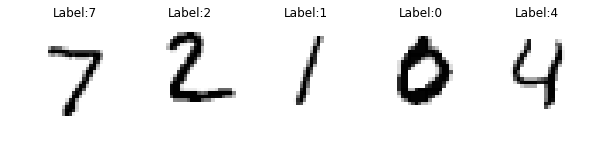

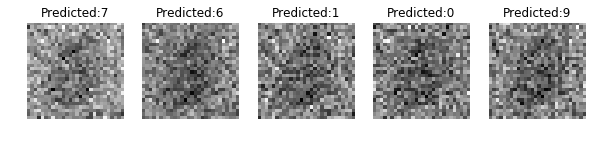

In [13]:
sample_images = sample_images.reshape([-1, 28, 28])
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(y_test[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(reconstructions[index], cmap="binary")
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.axis("off")